# Model assessment: LOO-CV for factory data with Stan


If this is to be executed, please execute the source code at the end of the report first. The report addresses the first two points of the assignment for each model, then give conlusion on the differences between models.

## SEPARATE MODEL


**psis-loo, p_eff, k-values**

PSIS-LOO value is -132.1610216250452
p_eff value is 9.689751572428591
Histogram of k-values:


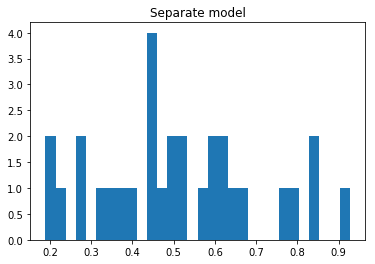

In [56]:
get_separate_result()

**Assement based on k-values**

As can be seen from the histogram, there are **several k-values** > 0.7 , which is still very small w.r.t the number of samples. Then PSIS-LOO is considered **reliable** in this case



## POOL MODEL


**psis-loo, p_eff, k-values**

PSIS-LOO value is -130.95795612034993
p_eff value is 1.9928311101955671
Histogram of k-values:


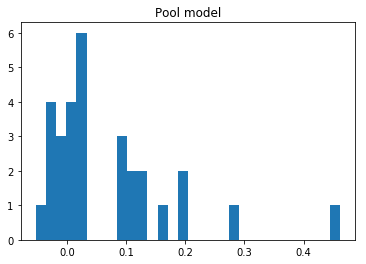

In [54]:
get_pool_result()

**Assement based on k-values**

As can be seen from the histogram, **all k-values < 0.7** (in fact all k-values are less than ~ 0.5). Then PSIS-LOO is considered **very reliable** in this case



## HIERARCHICAL MODEL

**psis-loo, p_eff, k-values**

PSIS-LOO value is -126.80815188646743
p_eff value is 5.604461670553292
Histogram of k-values:


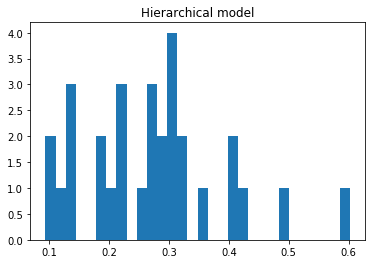

In [55]:
get_hierarchical_result()

**Assement based on k-values**

From the histogram, **all k-values < 0.7**. Then PSIS-LOO is considered **reliable** in this case



-------------------------------

##  CONCLUSION ON DIFFERENCE BETWEEN MODELS

All models are reliable even with different distribution of k-values. If we consider towards model with best predictive accuracy, then **HIERARCHICAL MODEL** should be selected, because its PSIS-LOO value is the highest (or the sum of log predictive density is the highest)

 
-------------------------------

**SOURCE CODE**  

Some bootstraping code and common function

In [1]:
import pystan
import numpy as np
import pickle
import matplotlib.pyplot as plt
from psis import psisloo

np.random.seed(seed=123)
raw_data = np.loadtxt('factory.txt')
data = dict(N=5, K=6, y=raw_data)


Model codes. From top to bottom: separate, pool, hierarchical

In [90]:
%%capture
hierarchical_model = """
data {
  int<lower=0> N;
  int<lower=0> K;
  matrix[N,K] y;
}
parameters {
  real theta0; // common theta for each K machine theta
  real<lower=0> sigma0; // machine specific sigma
  real theta[K]; // machine specific theta
  real<lower=0> sigma; // common std
}
model {
  for (k in 1:K)
    theta[k] ~ normal(theta0, sigma0);
  for (k in 1:K)
    y[:,k] ~ normal(theta[k], sigma);
}
generated quantities {
    real ypred[K]
    matrix[N,K] log_lik;
    for (k in 1:K)
      ypred[k] = normal_rng(theta[k], sigma)
      for (i in 1:N)
        log_lik[i,k] = normal_lpdf(y[i,k] | theta[k], sigma);
}
"""

hierarchical_sm = pystan.StanModel(model_code=hierarchical_model)
hierarchical_fit = hierarchical_sm.sampling(data=data, iter=2000, chains=4)

ValueError: Failed to parse Stan model 'anon_model_c2fa42c3502267859758f07ba1d92bb8'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

  error in 'unknown file name' at line 21, column 5
  -------------------------------------------------
    19: generated quantities {
    20:     real ypred[K]
    21:     matrix[N,K] log_lik;
            ^
    22:     for (k in 1:K)
  -------------------------------------------------

PARSER EXPECTED: ";"


In [89]:
lp = hierarchical_fit['lp__']
theta = hierarchical_fit['theta']
log_lik = hierarchical_fit['log_lik']
print(theta.shape)
print(log_lik.shape)


(4000, 6)
(4000, 5, 6)


In [86]:
print(theta[:,0]) # theta val of machine 1 in all simulation
print(np.exp((log_lik[:,:,0]))) # density of 5 observation in machine 1 in all simulation

[82.54143338 79.91926633 85.53571775 ... 81.09147815 77.38233303
 79.3055528 ]
[[0.02357113 0.02016843 0.02016843 0.00228874 0.01546358]
 [0.02808244 0.0196869  0.0196869  0.00144055 0.01864141]
 [0.02599052 0.02406028 0.02406028 0.00086957 0.01245213]
 ...
 [0.0256039  0.02011624 0.02011624 0.00196469 0.0170326 ]
 [0.02403455 0.01649265 0.01649265 0.00334781 0.02052938]
 [0.02788095 0.01893459 0.01893459 0.00157413 0.01942374]]


In [88]:
foo = [0.02357113, 0.02016843, 0.02016843, 0.00228874, 0.01546358]
np.sum(foo)

0.08166031